### DÉTECTION DE FRAUDE DANS LE SECTEUR BANCAIRE (EDA)

**Analyse Exploratoire Intensive des Données de Transactions par Carte de Crédit**
 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

#### 1. CHARGEMENT ET APERÇU DES DONNÉES

In [ ]:
# Charger les données
df = pd.read_csv(' /data/fraudAll.csv')

In [5]:
print(f"\n📊 Dimensions du dataset: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"💾 Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


📊 Dimensions du dataset: 1,296,675 lignes × 23 colonnes
💾 Taille mémoire: 1034.99 MB


In [6]:
print("Premières lignes du dataset:")

df.head()

Premières lignes du dataset:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
print("Informations sur les colonnes:")

print(df.info())

Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  

#### 2. PRÉSENTATION ET DESCRIPTION DÉTAILLÉE DES FEATURES

In [8]:
features_description = {
    'Unnamed: 0': {
        'Type': 'Integer',
        'Description': 'Index de la transaction (identifiant unique)',
        'Utilité': 'Identification et traçabilité des transactions'
    },
    'trans_date_trans_time': {
        'Type': 'Datetime',
        'Description': 'Date et heure exacte de la transaction',
        'Utilité': 'Analyse temporelle, détection de patterns horaires/journaliers'
    },
    'cc_num': {
        'Type': 'Integer',
        'Description': 'Numéro de carte de crédit (anonymisé)',
        'Utilité': 'Identification du client, analyse du comportement par carte'
    },
    'merchant': {
        'Type': 'String',
        'Description': 'Nom du commerçant où la transaction a été effectuée',
        'Utilité': 'Analyse des patterns par commerçant, détection de marchands suspects'
    },
    'category': {
        'Type': 'Categorical',
        'Description': 'Catégorie du commerçant (ex: grocery, gas, entertainment)',
        'Utilité': 'Analyse sectorielle, profils de dépenses par catégorie'
    },
    'amt': {
        'Type': 'Float',
        'Description': 'Montant de la transaction en dollars ($)',
        'Utilité': 'Analyse des montants, détection de transactions anormales'
    },
    'first': {
        'Type': 'String',
        'Description': 'Prénom du titulaire de la carte',
        'Utilité': 'Identification client (avec nom de famille)'
    },
    'last': {
        'Type': 'String',
        'Description': 'Nom de famille du titulaire de la carte',
        'Utilité': 'Identification client (avec prénom)'
    },
    'gender': {
        'Type': 'Categorical',
        'Description': 'Genre du titulaire (M/F)',
        'Utilité': 'Analyse démographique, segmentation'
    },
    'street': {
        'Type': 'String',
        'Description': 'Adresse postale du titulaire',
        'Utilité': 'Localisation géographique précise'
    },
    'city': {
        'Type': 'String',
        'Description': 'Ville de résidence du titulaire',
        'Utilité': 'Analyse géographique, patterns urbains'
    },
    'state': {
        'Type': 'Categorical',
        'Description': 'État de résidence (code à 2 lettres)',
        'Utilité': 'Analyse géographique par état'
    },
    'zip': {
        'Type': 'Integer',
        'Description': 'Code postal de résidence',
        'Utilité': 'Géolocalisation, analyse socio-économique'
    },
    'lat': {
        'Type': 'Float',
        'Description': 'Latitude de la résidence du titulaire',
        'Utilité': 'Géolocalisation précise, calcul de distances'
    },
    'long': {
        'Type': 'Float',
        'Description': 'Longitude de la résidence du titulaire',
        'Utilité': 'Géolocalisation précise, calcul de distances'
    },
    'city_pop': {
        'Type': 'Integer',
        'Description': 'Population de la ville de résidence',
        'Utilité': 'Analyse socio-démographique, contexte urbain/rural'
    },
    'job': {
        'Type': 'String',
        'Description': 'Profession du titulaire de la carte',
        'Utilité': 'Analyse socio-professionnelle, profils de revenus'
    },
    'dob': {
        'Type': 'Date',
        'Description': 'Date de naissance du titulaire',
        'Utilité': 'Calcul de l\'âge, analyse générationnelle'
    },
    'trans_num': {
        'Type': 'String',
        'Description': 'Identifiant unique de la transaction (hash)',
        'Utilité': 'Traçabilité, jointure avec autres tables'
    },
    'unix_time': {
        'Type': 'Integer',
        'Description': 'Timestamp Unix de la transaction',
        'Utilité': 'Calculs temporels, mesure d\'intervalles'
    },
    'merch_lat': {
        'Type': 'Float',
        'Description': 'Latitude du commerçant',
        'Utilité': 'Géolocalisation du commerce, calcul de distance'
    },
    'merch_long': {
        'Type': 'Float',
        'Description': 'Longitude du commerçant',
        'Utilité': 'Géolocalisation du commerce, calcul de distance'
    },
    'is_fraud': {
        'Type': 'Binary (0/1)',
        'Description': 'Variable cible: 1=Fraude, 0=Transaction légitime',
        'Utilité': 'Label pour la modélisation, analyse des patterns frauduleux'
    }
}

In [9]:
for feature, info in features_description.items():
    print(f"\n📌 {feature}")
    print(f"   Type: {info['Type']}")
    print(f"   Description: {info['Description']}")
    print(f"   Utilité: {info['Utilité']}")


📌 Unnamed: 0
   Type: Integer
   Description: Index de la transaction (identifiant unique)
   Utilité: Identification et traçabilité des transactions

📌 trans_date_trans_time
   Type: Datetime
   Description: Date et heure exacte de la transaction
   Utilité: Analyse temporelle, détection de patterns horaires/journaliers

📌 cc_num
   Type: Integer
   Description: Numéro de carte de crédit (anonymisé)
   Utilité: Identification du client, analyse du comportement par carte

📌 merchant
   Type: String
   Description: Nom du commerçant où la transaction a été effectuée
   Utilité: Analyse des patterns par commerçant, détection de marchands suspects

📌 category
   Type: Categorical
   Description: Catégorie du commerçant (ex: grocery, gas, entertainment)
   Utilité: Analyse sectorielle, profils de dépenses par catégorie

📌 amt
   Type: Float
   Description: Montant de la transaction en dollars ($)
   Utilité: Analyse des montants, détection de transactions anormales

📌 first
   Type: Strin

#### 3. STATISTIQUES DESCRIPTIVES GLOBALES

In [10]:
print("Variables numériques:")

df.describe().T

Variables numériques:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1296675.0,6.483370e+05,3.743180e+05,0.000000e+00,3.241685e+05,6.483370e+05,9.725055e+05,1.296674e+06
cc_num,1296675.0,4.171920e+17,1.308806e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1296675.0,7.035104e+01,1.603160e+02,1.000000e+00,9.650000e+00,4.752000e+01,8.314000e+01,2.894890e+04
zip,1296675.0,4.880067e+04,2.689322e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.978300e+04
lat,1296675.0,3.853762e+01,5.075808e+00,2.002710e+01,3.462050e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1296675.0,-9.022634e+01,1.375908e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1296675.0,8.882444e+04,3.019564e+05,2.300000e+01,7.430000e+02,2.456000e+03,2.032800e+04,2.906700e+06
unix_time,1296675.0,1.349244e+09,1.284128e+07,1.325376e+09,1.338751e+09,1.349250e+09,1.359385e+09,1.371817e+09
merch_lat,1296675.0,3.853734e+01,5.109788e+00,1.902779e+01,3.473357e+01,3.936568e+01,4.195716e+01,6.751027e+01
merch_long,1296675.0,-9.022646e+01,1.377109e+01,-1.666712e+02,-9.689728e+01,-8.743839e+01,-8.023680e+01,-6.695090e+01


In [11]:
df.amt.quantile(0.99)

545.9926000000002

In [12]:
df[df.amt == df.amt.max()]

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
787549,787549,2019-12-01 16:19:23,4979422371139333,fraud_Satterfield-Lowe,travel,28948.9,Kelly,Zimmerman,F,1893 Katie Tunnel,Westerville,NE,68881,41.4193,-99.3844,73,Product designer,1935-02-10,309c4bf7fc47b1ddee5ad883bcf634b6,1354378763,42.317313,-99.139498,0


In [13]:
print("Variables catégorielles:")

categorical_cols = ['gender', 'category', 'state']
for col in categorical_cols:
    print(df[col].value_counts().head(10))
    print()

Variables catégorielles:
gender
F    709863
M    586812
Name: count, dtype: int64

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
Name: count, dtype: int64

state
TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
Name: count, dtype: int64



#### 4. ANALYSE DE LA VARIABLE CIBLE (FRAUDE)

In [14]:
fraud_counts = df['is_fraud'].value_counts()
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100

In [15]:
print(f"\n🎯 Distribution des fraudes:")
print(f"   Transactions légitimes: {fraud_counts[0]:,} ({fraud_percentage[0]:.2f}%)")
print(f"   Transactions frauduleuses: {fraud_counts[1]:,} ({fraud_percentage[1]:.2f}%)")
print(f"   Ratio fraude/légitime: 1:{int(fraud_counts[0]/fraud_counts[1])}")
print(f"\n⚠️  Dataset FORTEMENT DÉSÉQUILIBRÉ - Techniques de rééquilibrage nécessaires!")


🎯 Distribution des fraudes:
   Transactions légitimes: 1,289,169 (99.42%)
   Transactions frauduleuses: 7,506 (0.58%)
   Ratio fraude/légitime: 1:171

⚠️  Dataset FORTEMENT DÉSÉQUILIBRÉ - Techniques de rééquilibrage nécessaires!


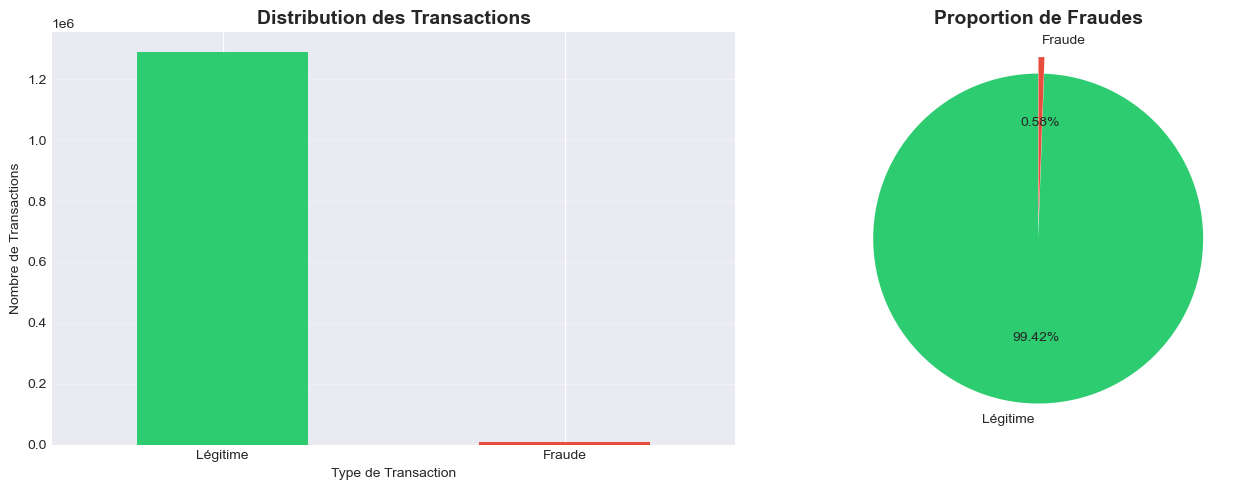

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Comptage
df['is_fraud'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution des Transactions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Type de Transaction')
axes[0].set_ylabel('Nombre de Transactions')
axes[0].set_xticklabels(['Légitime', 'Fraude'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2: Pourcentage
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_counts, labels=['Légitime', 'Fraude'], autopct='%1.2f%%',
            colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Proportion de Fraudes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./png/fraud_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### 5. ANALYSE DES VALEURS MANQUANTES

In [17]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

In [18]:
missing_df = pd.DataFrame({
    'Colonnes': missing_values.index,
    'Valeurs Manquantes': missing_values.values,
    'Pourcentage (%)': missing_percentage.values
})

In [19]:
missing_df = missing_df[missing_df['Valeurs Manquantes'] > 0].sort_values('Valeurs Manquantes', ascending=False)

In [20]:
if len(missing_df) > 0:
    print("\n⚠️  Valeurs manquantes détectées:")
    print(missing_df.to_string(index=False))
else:
    print("\n✅ Aucune valeur manquante détectée dans le dataset!")


✅ Aucune valeur manquante détectée dans le dataset!


#### 6. FEATURE ENGINEERING - CRÉATION DE NOUVELLES VARIABLES

In [18]:
# Conversion de la date
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  object        
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  object        
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  object        
 11  state                  1296675 non-null  object        
 12  zip                    12966

In [20]:
# Extraction de features temporelles
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [21]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,day,month,year,is_weekend
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,1,2019,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,1,2019,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,1,2019,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,1,2019,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,1,2019,0


In [22]:
# Période de la journée
def get_time_period(hour):
    if 0 <= hour < 6:
        return 'Nuit (0h-6h)'
    elif 6 <= hour < 12:
        return 'Matin (6h-12h)'
    elif 12 <= hour < 18:
        return 'Après-midi (12h-18h)'
    else:
        return 'Soirée (18h-24h)'

df['time_period'] = df['hour'].apply(get_time_period)

In [23]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,day,month,year,is_weekend,time_period
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,1,2019,0,Nuit (0h-6h)
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,1,2019,0,Nuit (0h-6h)
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,1,2019,0,Nuit (0h-6h)
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,1,2019,0,Nuit (0h-6h)
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,1,2019,0,Nuit (0h-6h)


In [24]:
# Âge du client
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days / 365.25

In [25]:
# Catégorie d'âge
def get_age_category(age):
    if age < 25:
        return '18-25 ans'
    elif age < 35:
        return '25-35 ans'
    elif age < 45:
        return '35-45 ans'
    elif age < 55:
        return '45-55 ans'
    elif age < 65:
        return '55-65 ans'
    else:
        return '65+ ans'

df['age_category'] = df['age'].apply(get_age_category)

In [26]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,day,month,year,is_weekend,time_period,age,age_category
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,1,2019,0,Nuit (0h-6h),30.814511,25-35 ans
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,1,2019,0,Nuit (0h-6h),40.531143,35-45 ans
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,1,2019,0,Nuit (0h-6h),56.950034,55-65 ans
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,1,2019,0,Nuit (0h-6h),51.969884,45-55 ans
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,1,2019,0,Nuit (0h-6h),32.763860,25-35 ans


In [27]:
# Distance entre client et commerçant (formule de Haversine simplifiée)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Rayon de la Terre en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    # formule de Heversine
    c = 2 * np.arcsin(np.sqrt(a))
    # angle central entre les deux points (en radians)
    return R * c # distance

df['distance_km'] = haversine_distance(df['lat'], df['long'], 
                                        df['merch_lat'], df['merch_long'])

In [29]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,day,month,year,is_weekend,time_period,age,age_category,distance_km
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,1,2019,0,Nuit (0h-6h),30.814511,25-35 ans,78.597568
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,1,2019,0,Nuit (0h-6h),40.531143,35-45 ans,30.212176
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,1,2019,0,Nuit (0h-6h),56.950034,55-65 ans,108.206083
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,1,2019,0,Nuit (0h-6h),51.969884,45-55 ans,95.673231
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,1,2019,0,Nuit (0h-6h),32.763860,25-35 ans,77.556744


In [30]:
# Catégorie de distance
def get_distance_category(dist):
    if dist < 5:
        return 'Très proche (<5km)'
    elif dist < 20:
        return 'Proche (5-20km)'
    elif dist < 100:
        return 'Moyen (20-100km)'
    else:
        return 'Lointain (>100km)'

df['distance_category'] = df['distance_km'].apply(get_distance_category)

In [31]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,day,month,year,is_weekend,time_period,age,age_category,distance_km,distance_category
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,1,2019,0,Nuit (0h-6h),30.814511,25-35 ans,78.597568,Moyen (20-100km)
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,1,2019,0,Nuit (0h-6h),40.531143,35-45 ans,30.212176,Moyen (20-100km)
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,1,2019,0,Nuit (0h-6h),56.950034,55-65 ans,108.206083,Lointain (>100km)
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,1,2019,0,Nuit (0h-6h),51.969884,45-55 ans,95.673231,Moyen (20-100km)
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,1,2019,0,Nuit (0h-6h),32.763860,25-35 ans,77.556744,Moyen (20-100km)


In [37]:
# Catégorie de montant
def get_amount_category(amt):
    if amt < 10:
        return 'Micro (<10$)'
    elif amt < 50:
        return 'Petit (10-50$)'
    elif amt < 100:
        return 'Moyen (50-100$)'
    elif amt < 500:
        return 'Élevé (100-500$)'
    else:
        return 'Très élevé (>500$)'

df['amount_category'] = df['amt'].apply(get_amount_category)

In [38]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,day,month,year,is_weekend,time_period,age,age_category,distance_km,distance_category,amount_category
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1,1,2019,0,Nuit (0h-6h),30.814511,25-35 ans,78.597568,Moyen (20-100km),Micro (<10$)
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1,1,2019,0,Nuit (0h-6h),40.531143,35-45 ans,30.212176,Moyen (20-100km),Élevé (100-500$)
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1,1,2019,0,Nuit (0h-6h),56.950034,55-65 ans,108.206083,Lointain (>100km),Élevé (100-500$)
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1,1,2019,0,Nuit (0h-6h),51.969884,45-55 ans,95.673231,Moyen (20-100km),Petit (10-50$)
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1,1,2019,0,Nuit (0h-6h),32.763860,25-35 ans,77.556744,Moyen (20-100km),Petit (10-50$)


In [39]:
print("\n✅ Nouvelles features créées:")
new_features = ['hour', 'day_of_week', 'month', 'is_weekend', 'time_period', 
                'age', 'age_category', 'distance_km', 'distance_category', 'amount_category']
for feat in new_features:
    print(f"   • {feat}")


✅ Nouvelles features créées:
   • hour
   • day_of_week
   • month
   • is_weekend
   • time_period
   • age
   • age_category
   • distance_km
   • distance_category
   • amount_category


#### 7. ANALYSE DES MONTANTS DE TRANSACTIONS

In [40]:
print("Statistiques des montants par type:")

df.groupby('is_fraud')['amt'].describe()

Statistiques des montants par type:


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


In [41]:
fraud_amounts = df[df['is_fraud'] == 1]['amt']
legit_amounts = df[df['is_fraud'] == 0]['amt']

In [42]:
print(f"\n💰 Montant moyen:")
print(f"   Transactions légitimes: ${legit_amounts.mean():.2f}")
print(f"   Transactions frauduleuses: ${fraud_amounts.mean():.2f}")
print(f"   Différence: ${abs(fraud_amounts.mean() - legit_amounts.mean()):.2f}")


💰 Montant moyen:
   Transactions légitimes: $67.67
   Transactions frauduleuses: $531.32
   Différence: $463.65


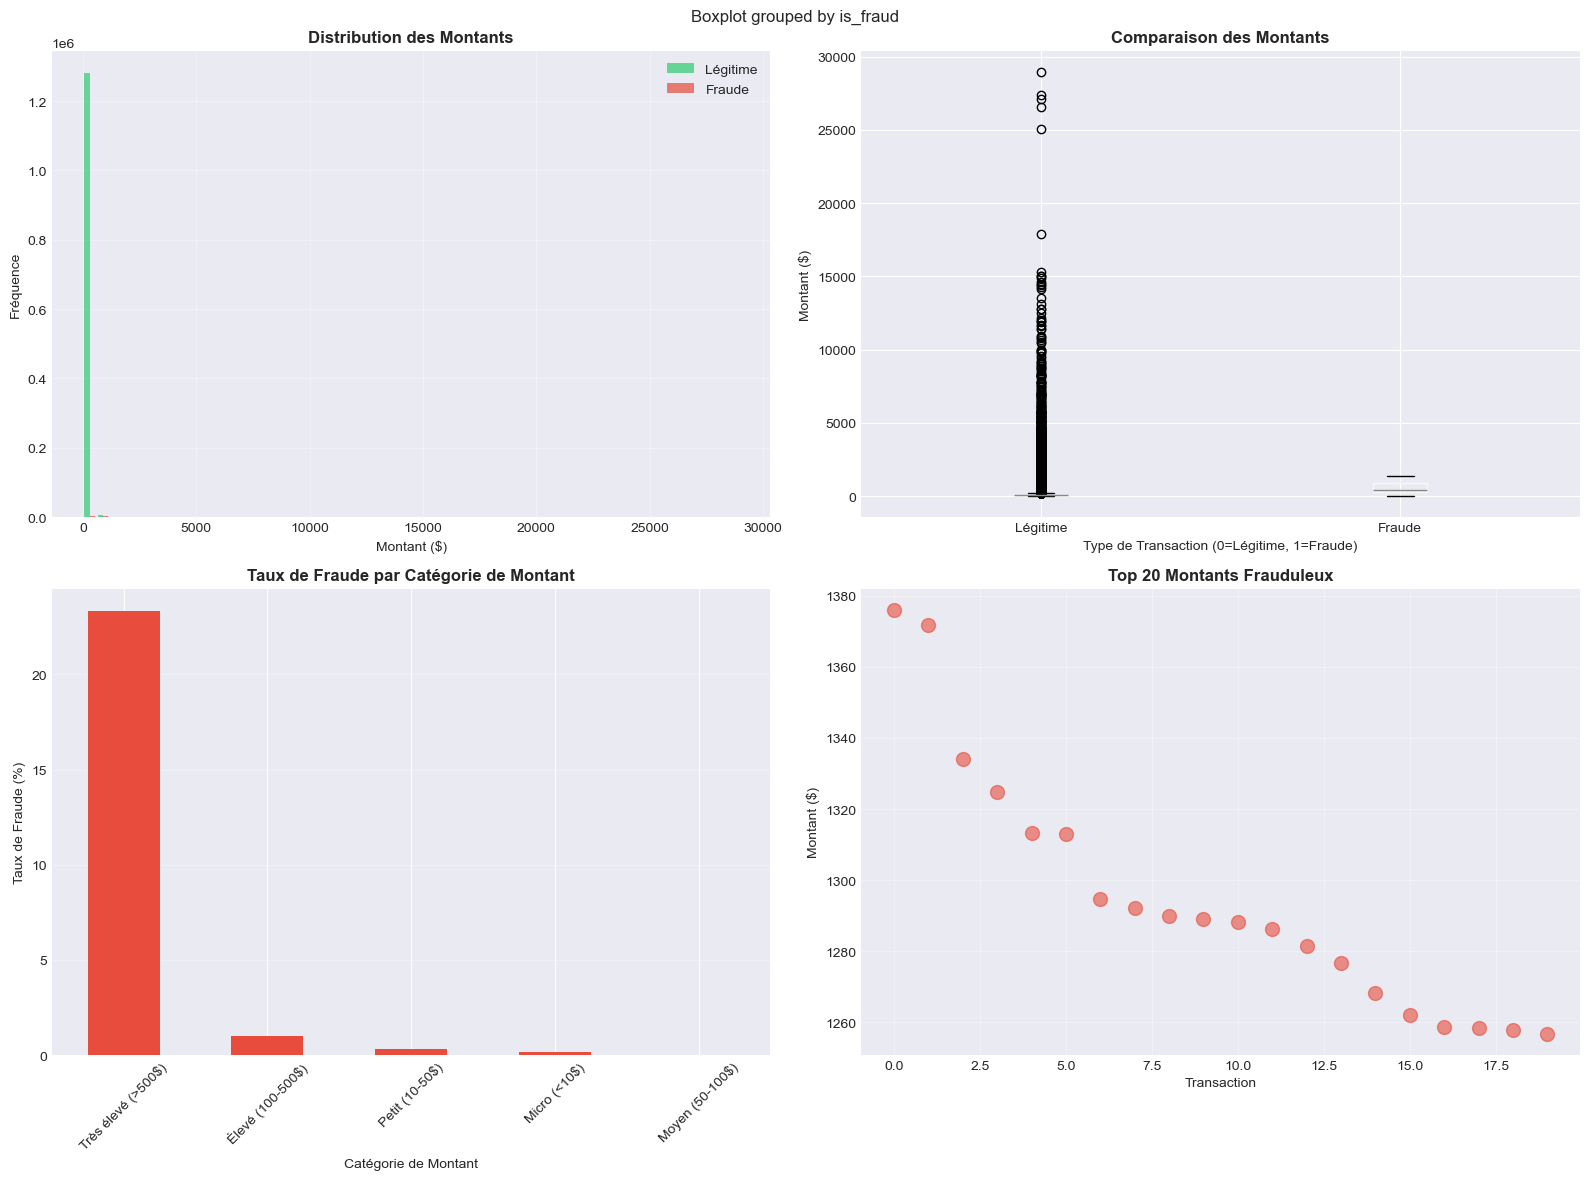

In [43]:
# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution des montants (légitime vs fraude)
axes[0, 0].hist([legit_amounts, fraud_amounts], bins=50, label=['Légitime', 'Fraude'],
                color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0, 0].set_xlabel('Montant ($)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des Montants', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot comparatif
df.boxplot(column='amt', by='is_fraud', ax=axes[0, 1])
axes[0, 1].set_xlabel('Type de Transaction (0=Légitime, 1=Fraude)')
axes[0, 1].set_ylabel('Montant ($)')
axes[0, 1].set_title('Comparaison des Montants', fontweight='bold')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Légitime', 'Fraude'])

# Distribution par catégorie de montant
amount_fraud = df.groupby('amount_category')['is_fraud'].agg(['sum', 'count', 'mean'])
amount_fraud['fraud_rate'] = amount_fraud['mean'] * 100
amount_fraud = amount_fraud.sort_values('fraud_rate', ascending=False)

amount_fraud['fraud_rate'].plot(kind='bar', ax=axes[1, 0], color='#e74c3c')
axes[1, 0].set_xlabel('Catégorie de Montant')
axes[1, 0].set_ylabel('Taux de Fraude (%)')
axes[1, 0].set_title('Taux de Fraude par Catégorie de Montant', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Top montants frauduleux
top_fraud_amounts = df[df['is_fraud'] == 1].nlargest(20, 'amt')
axes[1, 1].scatter(range(len(top_fraud_amounts)), top_fraud_amounts['amt'], 
                   color='#e74c3c', s=100, alpha=0.6)
axes[1, 1].set_xlabel('Transaction')
axes[1, 1].set_ylabel('Montant ($)')
axes[1, 1].set_title('Top 20 Montants Frauduleux', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./png/amount_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 8. ANALYSE TEMPORELLE

In [40]:
# Fraudes par heure
print("Distribution horaire des fraudes:")
hourly_fraud = df.groupby('hour')['is_fraud'].agg(['sum', 'count', 'mean'])
hourly_fraud['fraud_rate'] = hourly_fraud['mean'] * 100
print(hourly_fraud.sort_values('fraud_rate', ascending=False).head(10))

Distribution horaire des fraudes:
       sum  count      mean  fraud_rate
hour                                   
22    1931  66982  0.028829    2.882864
23    1904  67104  0.028374    2.837387
1      658  42869  0.015349    1.534909
0      635  42502  0.014940    1.494047
2      625  42656  0.014652    1.465210
3      609  42769  0.014239    1.423929
5       60  42171  0.001423    0.142278
7       56  42203  0.001327    0.132692
14      86  64885  0.001325    0.132542
19      81  65508  0.001236    0.123649


In [41]:
# Fraudes par jour de la semaine
print("\n" + "-" * 80)
print("Distribution hebdomadaire des fraudes:")
print("-" * 80)
days_map = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 
            4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
daily_fraud = df.groupby('day_of_week')['is_fraud'].agg(['sum', 'count', 'mean'])
daily_fraud['fraud_rate'] = daily_fraud['mean'] * 100
daily_fraud.index = daily_fraud.index.map(days_map)
print(daily_fraud)


--------------------------------------------------------------------------------
Distribution hebdomadaire des fraudes:
--------------------------------------------------------------------------------
              sum   count      mean  fraud_rate
day_of_week                                    
Lundi        1182  254282  0.004648    0.464838
Mardi         935  160227  0.005835    0.583547
Mercredi      859  131073  0.006554    0.655360
Jeudi        1008  147285  0.006844    0.684387
Vendredi     1079  152272  0.007086    0.708600
Samedi       1227  200957  0.006106    0.610578
Dimanche     1216  250579  0.004853    0.485276


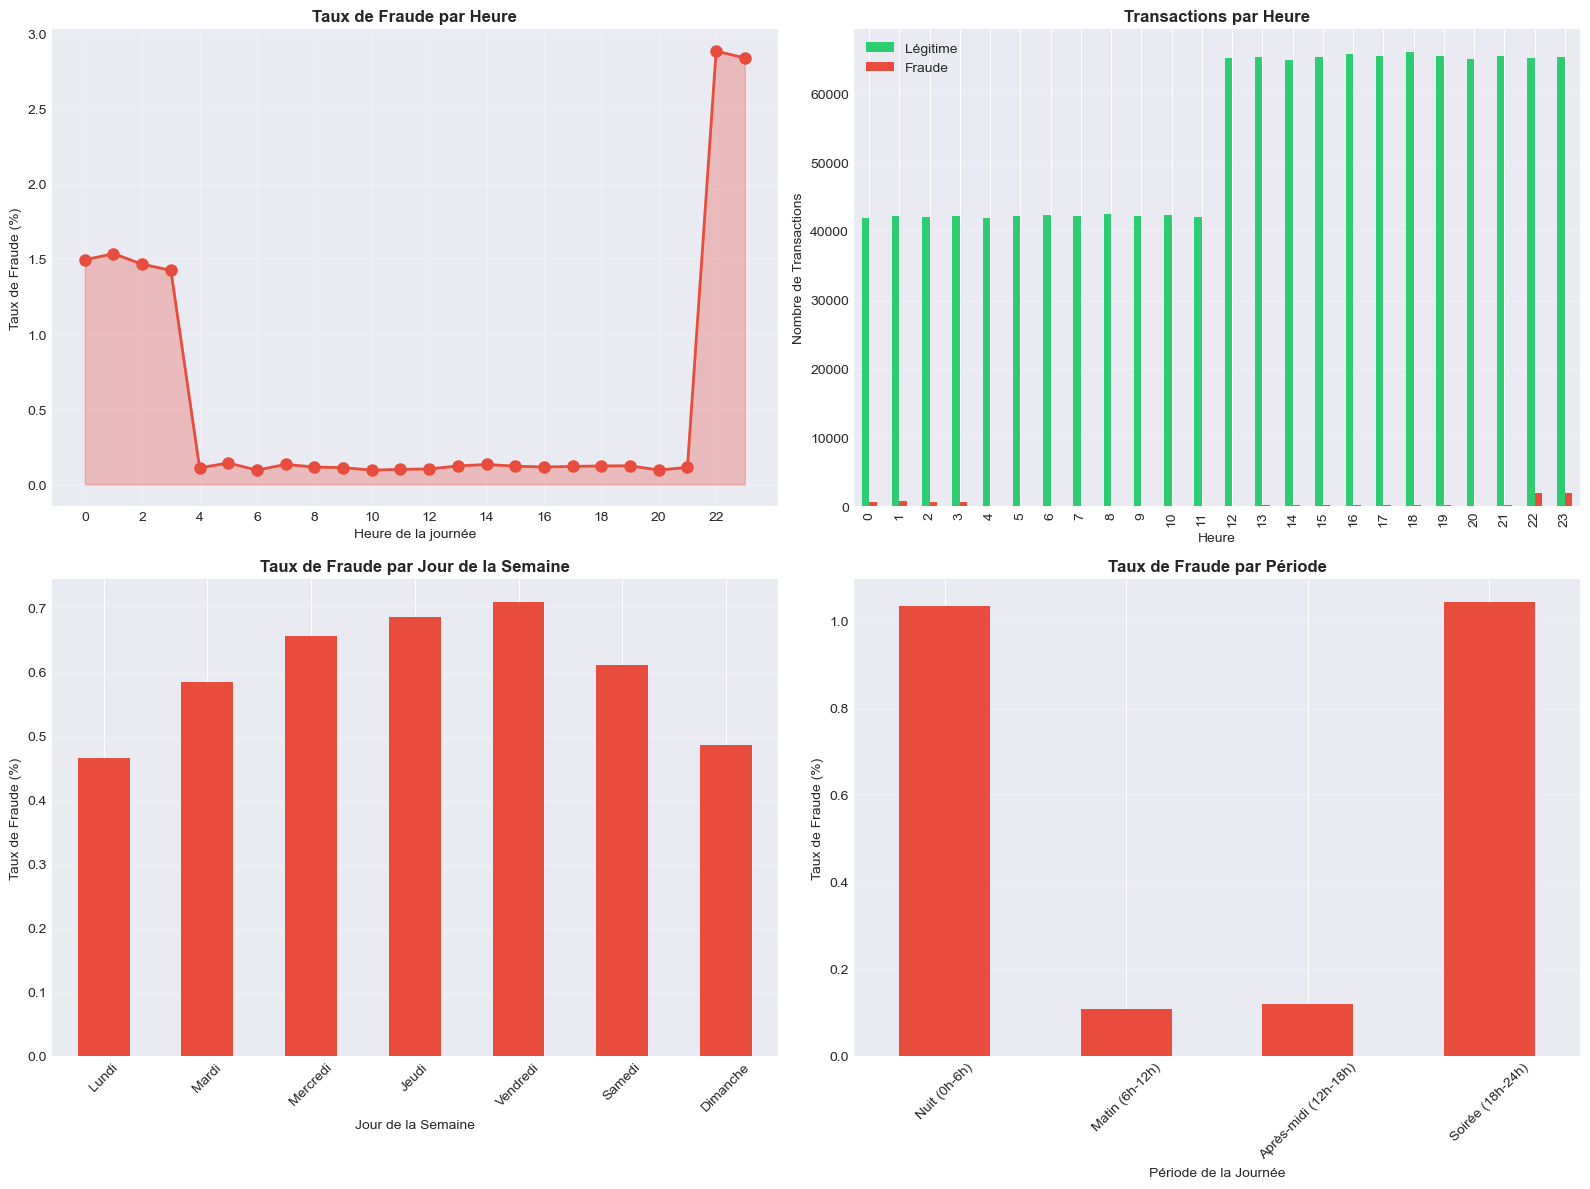

In [42]:
# Visualisations temporelles
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Fraudes par heure
axes[0, 0].plot(hourly_fraud.index, hourly_fraud['fraud_rate'], 
                marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 0].fill_between(hourly_fraud.index, hourly_fraud['fraud_rate'], alpha=0.3, color='#e74c3c')
axes[0, 0].set_xlabel('Heure de la journée')
axes[0, 0].set_ylabel('Taux de Fraude (%)')
axes[0, 0].set_title('Taux de Fraude par Heure', fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# Transactions par heure (légitime vs fraude)
hour_counts = df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)
hour_counts.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_xlabel('Heure')
axes[0, 1].set_ylabel('Nombre de Transactions')
axes[0, 1].set_title('Transactions par Heure', fontweight='bold')
axes[0, 1].legend(['Légitime', 'Fraude'])
axes[0, 1].grid(axis='y', alpha=0.3)

# Fraudes par jour de la semaine
daily_fraud['fraud_rate'].plot(kind='bar', ax=axes[1, 0], color='#e74c3c')
axes[1, 0].set_xlabel('Jour de la Semaine')
axes[1, 0].set_ylabel('Taux de Fraude (%)')
axes[1, 0].set_title('Taux de Fraude par Jour de la Semaine', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Fraudes par période de la journée
period_fraud = df.groupby('time_period')['is_fraud'].agg(['sum', 'count', 'mean'])
period_fraud['fraud_rate'] = period_fraud['mean'] * 100
period_order = ['Nuit (0h-6h)', 'Matin (6h-12h)', 'Après-midi (12h-18h)', 'Soirée (18h-24h)']
period_fraud = period_fraud.reindex(period_order)
period_fraud['fraud_rate'].plot(kind='bar', ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_xlabel('Période de la Journée')
axes[1, 1].set_ylabel('Taux de Fraude (%)')
axes[1, 1].set_title('Taux de Fraude par Période', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#### 9. ANALYSE PAR CATÉGORIE DE COMMERÇANTS

In [43]:
category_fraud = df.groupby('category')['is_fraud'].agg(['sum', 'count', 'mean'])
category_fraud['fraud_rate'] = category_fraud['mean'] * 100
category_fraud = category_fraud.sort_values('fraud_rate', ascending=False)

In [44]:
print("Taux de fraude par catégorie:")

category_fraud

Taux de fraude par catégorie:


,sum,count,mean,fraud_rate
category,,,,
shopping_net,1713,97543,0.017561,1.756149
misc_net,915,63287,0.014458,1.445795
grocery_pos,1743,123638,0.014098,1.409761
shopping_pos,843,116672,0.007225,0.722538
gas_transport,618,131659,0.004694,0.469394
misc_pos,250,79655,0.003139,0.313853
grocery_net,134,45452,0.002948,0.294817
travel,116,40507,0.002864,0.286370
entertainment,233,94014,0.002478,0.247835


In [45]:
print(f"\n⚠️  Catégories les plus risquées:")
for idx, (cat, row) in enumerate(category_fraud.head(5).iterrows(), 1):
    print(f"   {idx}. {cat}: {row['fraud_rate']:.2f}% ({int(row['sum'])} fraudes sur {int(row['count'])} transactions)")


⚠️  Catégories les plus risquées:
   1. shopping_net: 1.76% (1713 fraudes sur 97543 transactions)
   2. misc_net: 1.45% (915 fraudes sur 63287 transactions)
   3. grocery_pos: 1.41% (1743 fraudes sur 123638 transactions)
   4. shopping_pos: 0.72% (843 fraudes sur 116672 transactions)
   5. gas_transport: 0.47% (618 fraudes sur 131659 transactions)


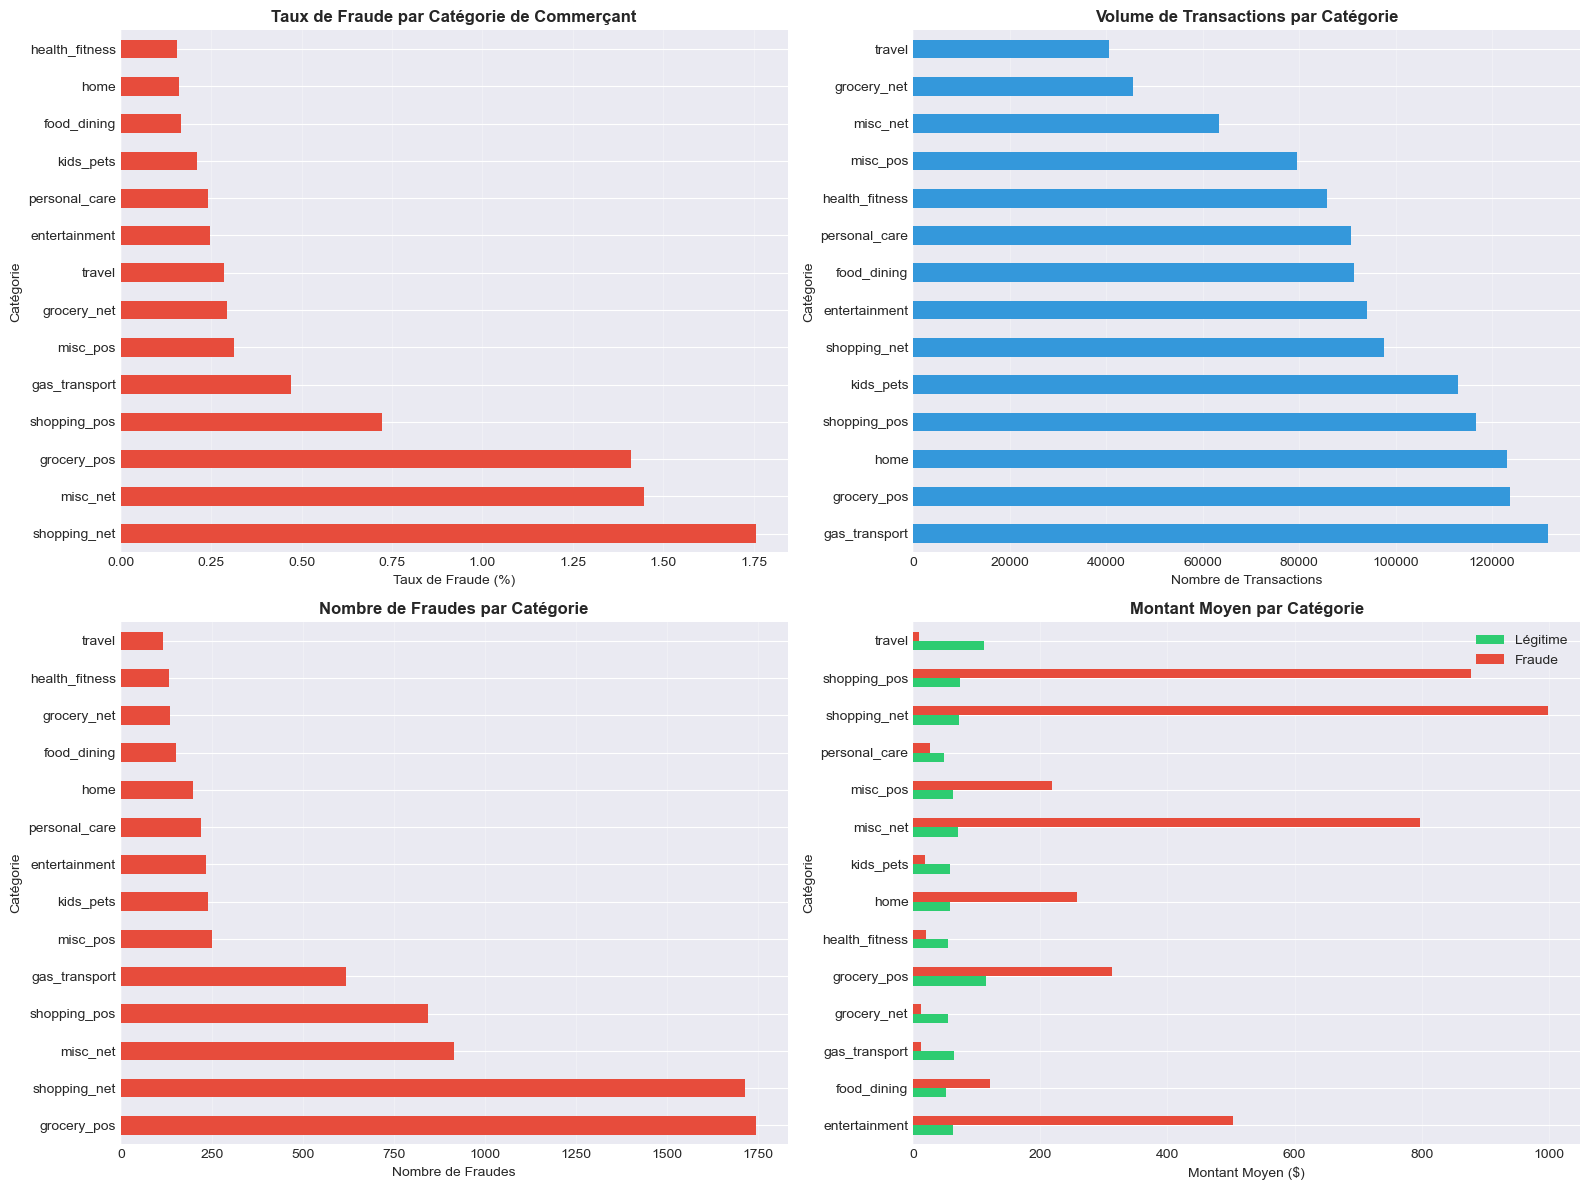

In [46]:
# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Taux de fraude par catégorie
category_fraud['fraud_rate'].plot(kind='barh', ax=axes[0, 0], color='#e74c3c')
axes[0, 0].set_xlabel('Taux de Fraude (%)')
axes[0, 0].set_ylabel('Catégorie')
axes[0, 0].set_title('Taux de Fraude par Catégorie de Commerçant', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Nombre de transactions par catégorie
category_fraud['count'].sort_values(ascending=False).plot(kind='barh', ax=axes[0, 1], color='#3498db')
axes[0, 1].set_xlabel('Nombre de Transactions')
axes[0, 1].set_ylabel('Catégorie')
axes[0, 1].set_title('Volume de Transactions par Catégorie', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Nombre de fraudes par catégorie
category_fraud['sum'].sort_values(ascending=False).plot(kind='barh', ax=axes[1, 0], color='#e74c3c')
axes[1, 0].set_xlabel('Nombre de Fraudes')
axes[1, 0].set_ylabel('Catégorie')
axes[1, 0].set_title('Nombre de Fraudes par Catégorie', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Montant moyen par catégorie et type de transaction
category_amount = df.groupby(['category', 'is_fraud'])['amt'].mean().unstack(fill_value=0)
category_amount.plot(kind='barh', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_xlabel('Montant Moyen ($)')
axes[1, 1].set_ylabel('Catégorie')
axes[1, 1].set_title('Montant Moyen par Catégorie', fontweight='bold')
axes[1, 1].legend(['Légitime', 'Fraude'])
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 10. ANALYSE GÉOGRAPHIQUE

In [47]:
# Fraudes par état
state_fraud = df.groupby('state')['is_fraud'].agg(['sum', 'count', 'mean'])
state_fraud['fraud_rate'] = state_fraud['mean'] * 100
state_fraud = state_fraud.sort_values('fraud_rate', ascending=False)

In [48]:
print("Top 15 états avec le plus haut taux de fraude:")

print(state_fraud.head(15))

Top 15 états avec le plus haut taux de fraude:
       sum  count      mean  fraud_rate
state                                  
DE       9      9  1.000000  100.000000
RI      15    550  0.027273    2.727273
AK      36   2120  0.016981    1.698113
NV      47   5607  0.008382    0.838238
CO     113  13880  0.008141    0.814121
OR     149  18597  0.008012    0.801204
TN     140  17554  0.007975    0.797539
NE     180  24168  0.007448    0.744786
ME     119  16505  0.007210    0.720994
NH      59   8278  0.007127    0.712733
OH     321  46480  0.006906    0.690620
KS     156  22996  0.006784    0.678379
VA     198  29250  0.006769    0.676923
NY     555  83501  0.006647    0.664663
SC     193  29190  0.006612    0.661185


In [49]:
# Analyse de la distance
print("Statistiques de distance (client-commerçant):")

print(df.groupby('is_fraud')['distance_km'].describe())

Statistiques de distance (client-commerçant):
              count       mean        std       min        25%        50%  \
is_fraud                                                                    
0         1289169.0  76.113756  29.119051  0.022255  55.332701  78.233012   
1            7506.0  76.268330  28.752602  0.738769  55.632890  77.931954   

                75%         max  
is_fraud                         
0         98.504498  152.117173  
1         98.391090  144.522410  


In [50]:
distance_fraud = df.groupby('distance_category')['is_fraud'].agg(['sum', 'count', 'mean'])
distance_fraud['fraud_rate'] = distance_fraud['mean'] * 100
print("\n" + "-" * 80)
print("Taux de fraude par catégorie de distance:")
print("-" * 80)
print(distance_fraud)


--------------------------------------------------------------------------------
Taux de fraude par catégorie de distance:
--------------------------------------------------------------------------------
                     sum   count      mean  fraud_rate
distance_category                                     
Lointain (>100km)   1747  302851  0.005769    0.576851
Moyen (20-100km)    5536  951434  0.005819    0.581859
Proche (5-20km)      213   39686  0.005367    0.536713
Très proche (<5km)    10    2704  0.003698    0.369822


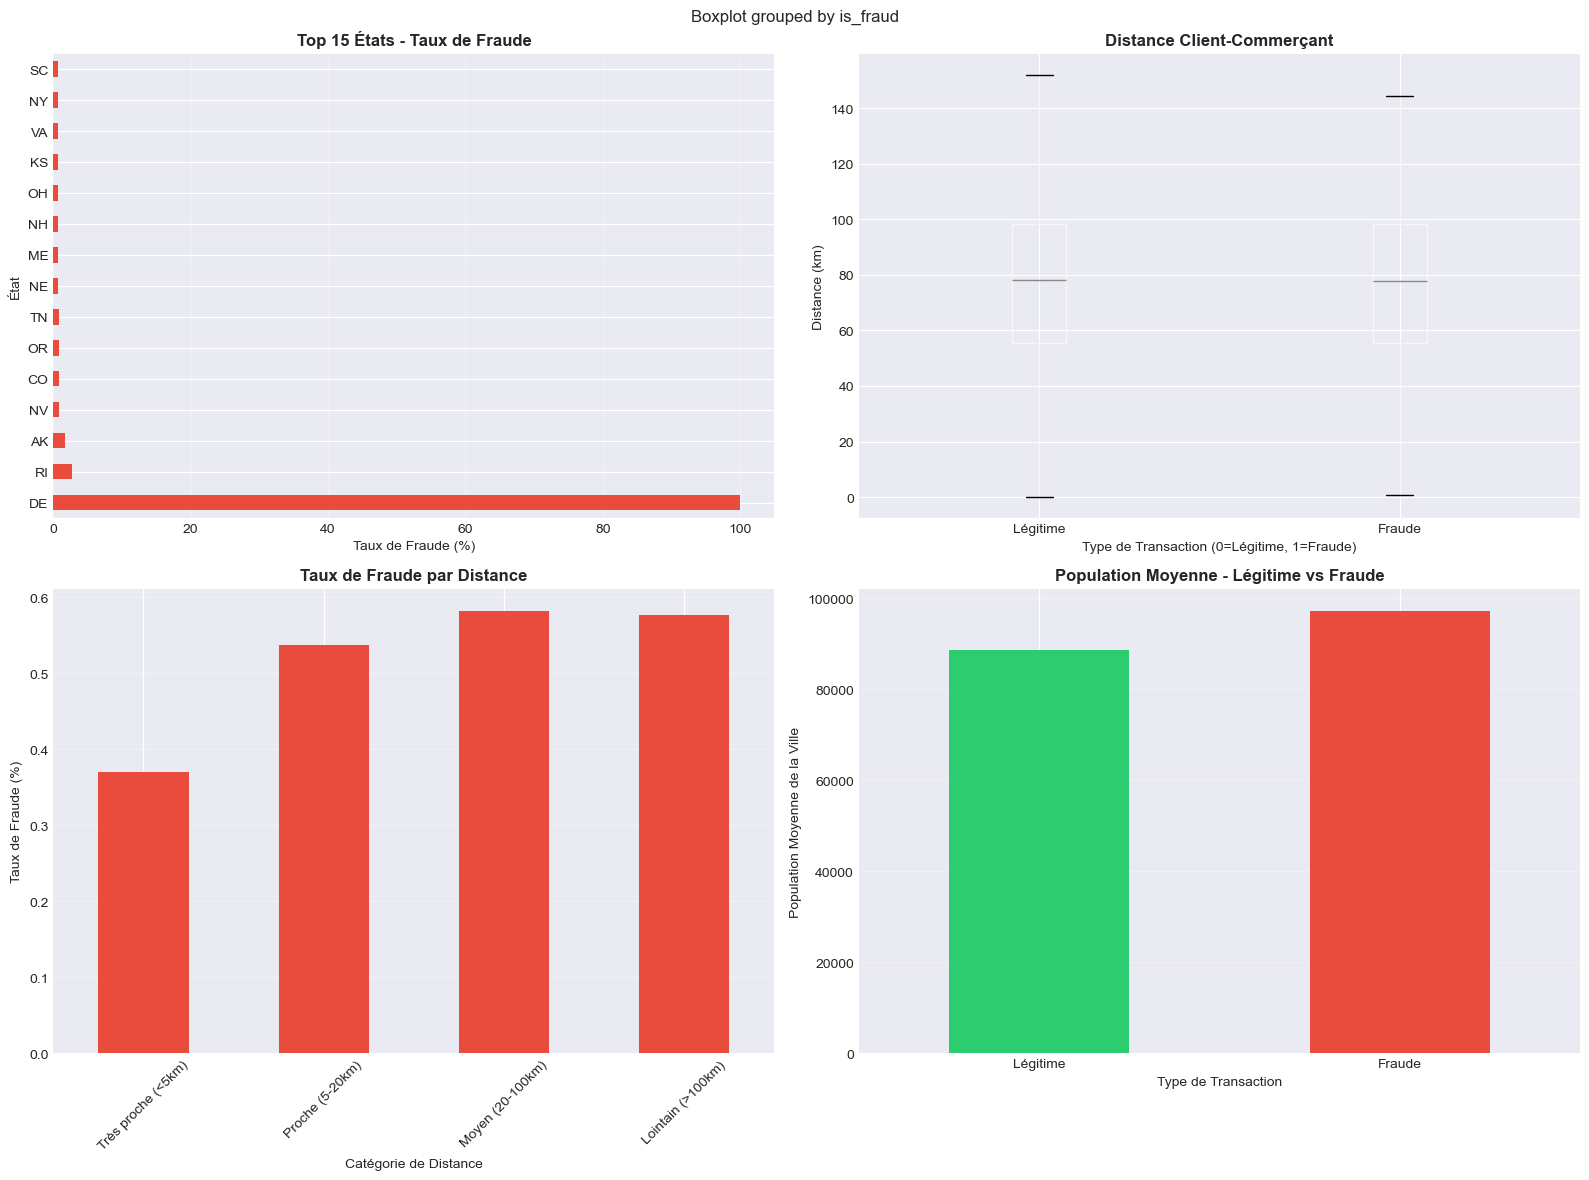

In [51]:
# Visualisations géographiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top états par taux de fraude
state_fraud.head(15)['fraud_rate'].plot(kind='barh', ax=axes[0, 0], color='#e74c3c')
axes[0, 0].set_xlabel('Taux de Fraude (%)')
axes[0, 0].set_ylabel('État')
axes[0, 0].set_title('Top 15 États - Taux de Fraude', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Distribution de la distance
df.boxplot(column='distance_km', by='is_fraud', ax=axes[0, 1])
axes[0, 1].set_xlabel('Type de Transaction (0=Légitime, 1=Fraude)')
axes[0, 1].set_ylabel('Distance (km)')
axes[0, 1].set_title('Distance Client-Commerçant', fontweight='bold')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Légitime', 'Fraude'])

# Taux de fraude par catégorie de distance
distance_order = ['Très proche (<5km)', 'Proche (5-20km)', 'Moyen (20-100km)', 'Lointain (>100km)']
distance_fraud_ordered = distance_fraud.reindex(distance_order)
distance_fraud_ordered['fraud_rate'].plot(kind='bar', ax=axes[1, 0], color='#e74c3c')
axes[1, 0].set_xlabel('Catégorie de Distance')
axes[1, 0].set_ylabel('Taux de Fraude (%)')
axes[1, 0].set_title('Taux de Fraude par Distance', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Population de la ville vs fraude
city_pop_fraud = df.groupby('is_fraud')['city_pop'].mean()
city_pop_fraud.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_xlabel('Type de Transaction')
axes[1, 1].set_ylabel('Population Moyenne de la Ville')
axes[1, 1].set_title('Population Moyenne - Légitime vs Fraude', fontweight='bold')
axes[1, 1].set_xticklabels(['Légitime', 'Fraude'], rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

La 4ème figure compare la population moyenne des villes d’origine des transactions légitimes vs frauduleuses.

➡️ La barre Fraude est plus haute, cela veut dire que les fraudes ont tendance à se produire dans des villes plus grandes en moyenne.

#### 11. ANALYSE DÉMOGRAPHIQUE

In [52]:
# Genre
gender_fraud = df.groupby('gender')['is_fraud'].agg(['sum', 'count', 'mean'])
gender_fraud['fraud_rate'] = gender_fraud['mean'] * 100

print("Fraude par genre:")

print(gender_fraud)

Fraude par genre:
         sum   count      mean  fraud_rate
gender                                    
F       3735  709863  0.005262    0.526158
M       3771  586812  0.006426    0.642625


In [53]:
# Âge
age_fraud = df.groupby('age_category')['is_fraud'].agg(['sum', 'count', 'mean'])
age_fraud['fraud_rate'] = age_fraud['mean'] * 100
age_order = ['18-25 ans', '25-35 ans', '35-45 ans', '45-55 ans', '55-65 ans', '65+ ans']
age_fraud = age_fraud.reindex(age_order)

print("Fraude par catégorie d'âge:")

print(age_fraud)

Fraude par catégorie d'âge:
               sum   count      mean  fraud_rate
age_category                                    
18-25 ans      764  121688  0.006278    0.627835
25-35 ans     1391  287749  0.004834    0.483407
35-45 ans     1163  272940  0.004261    0.426101
45-55 ans     1491  256553  0.005812    0.581166
55-65 ans     1259  164087  0.007673    0.767276
65+ ans       1438  193658  0.007425    0.742546


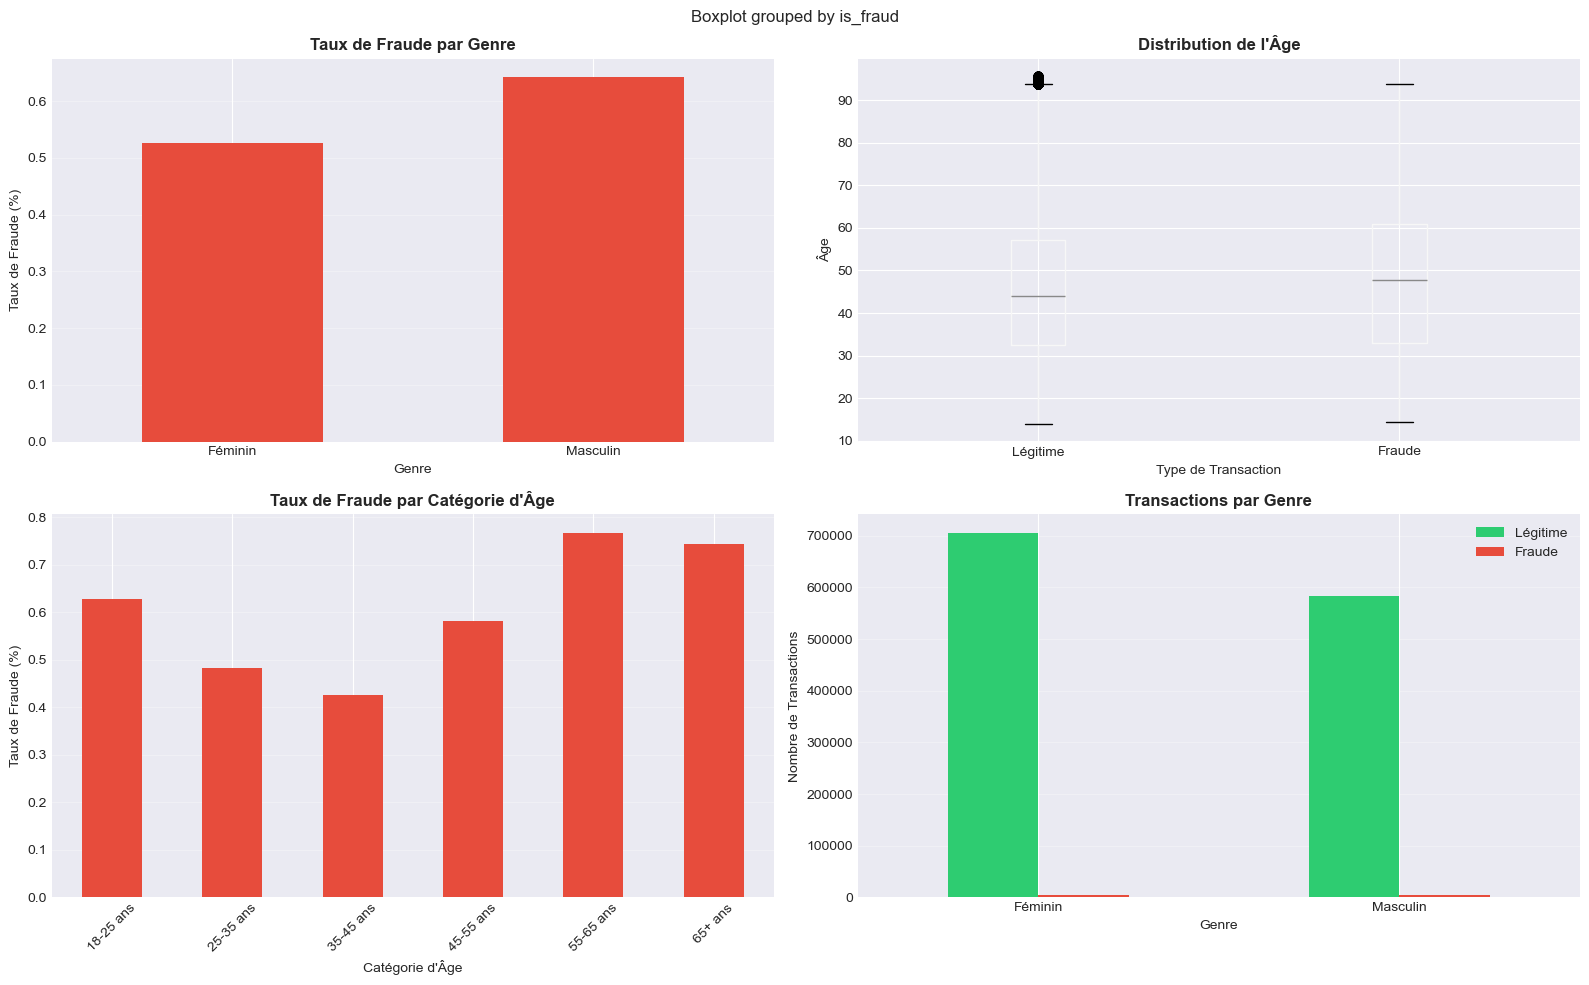

In [55]:
# Visualisations démographiques
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Genre
gender_fraud['fraud_rate'].plot(kind='bar', ax=axes[0, 0], color='#e74c3c')
axes[0, 0].set_xlabel('Genre')
axes[0, 0].set_ylabel('Taux de Fraude (%)')
axes[0, 0].set_title('Taux de Fraude par Genre', fontweight='bold')
axes[0, 0].set_xticklabels(['Féminin', 'Masculin'], rotation=0)
axes[0, 0].grid(axis='y', alpha=0.3)

# Distribution de l'âge
df.boxplot(column='age', by='is_fraud', ax=axes[0, 1])
axes[0, 1].set_xlabel('Type de Transaction')
axes[0, 1].set_ylabel('Âge')
axes[0, 1].set_title('Distribution de l\'Âge', fontweight='bold')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Légitime', 'Fraude'])

# Catégories d'âge
age_fraud['fraud_rate'].plot(kind='bar', ax=axes[1, 0], color='#e74c3c')
axes[1, 0].set_xlabel('Catégorie d\'Âge')
axes[1, 0].set_ylabel('Taux de Fraude (%)')
axes[1, 0].set_title('Taux de Fraude par Catégorie d\'Âge', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Distribution des transactions par genre
gender_counts = df.groupby(['gender', 'is_fraud']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_xlabel('Genre')
axes[1, 1].set_ylabel('Nombre de Transactions')
axes[1, 1].set_title('Transactions par Genre', fontweight='bold')
axes[1, 1].set_xticklabels(['Féminin', 'Masculin'], rotation=0)
axes[1, 1].legend(['Légitime', 'Fraude'])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/demographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 12. MATRICE DE CORRÉLATION

In [56]:
# Sélection des variables numériques pertinentes
numeric_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                'hour', 'day_of_week', 'month', 'age', 'distance_km', 'is_fraud']
correlation_matrix = df[numeric_cols].corr()

In [57]:
print("Corrélations avec la variable cible 'is_fraud':")

fraud_correlations = correlation_matrix['is_fraud'].sort_values(ascending=False)
print(fraud_correlations)

Corrélations avec la variable cible 'is_fraud':
is_fraud       1.000000
amt            0.219404
hour           0.013799
age            0.012270
city_pop       0.002136
lat            0.001894
merch_lat      0.001741
day_of_week    0.001739
merch_long     0.001721
long           0.001721
distance_km    0.000403
month         -0.012409
Name: is_fraud, dtype: float64


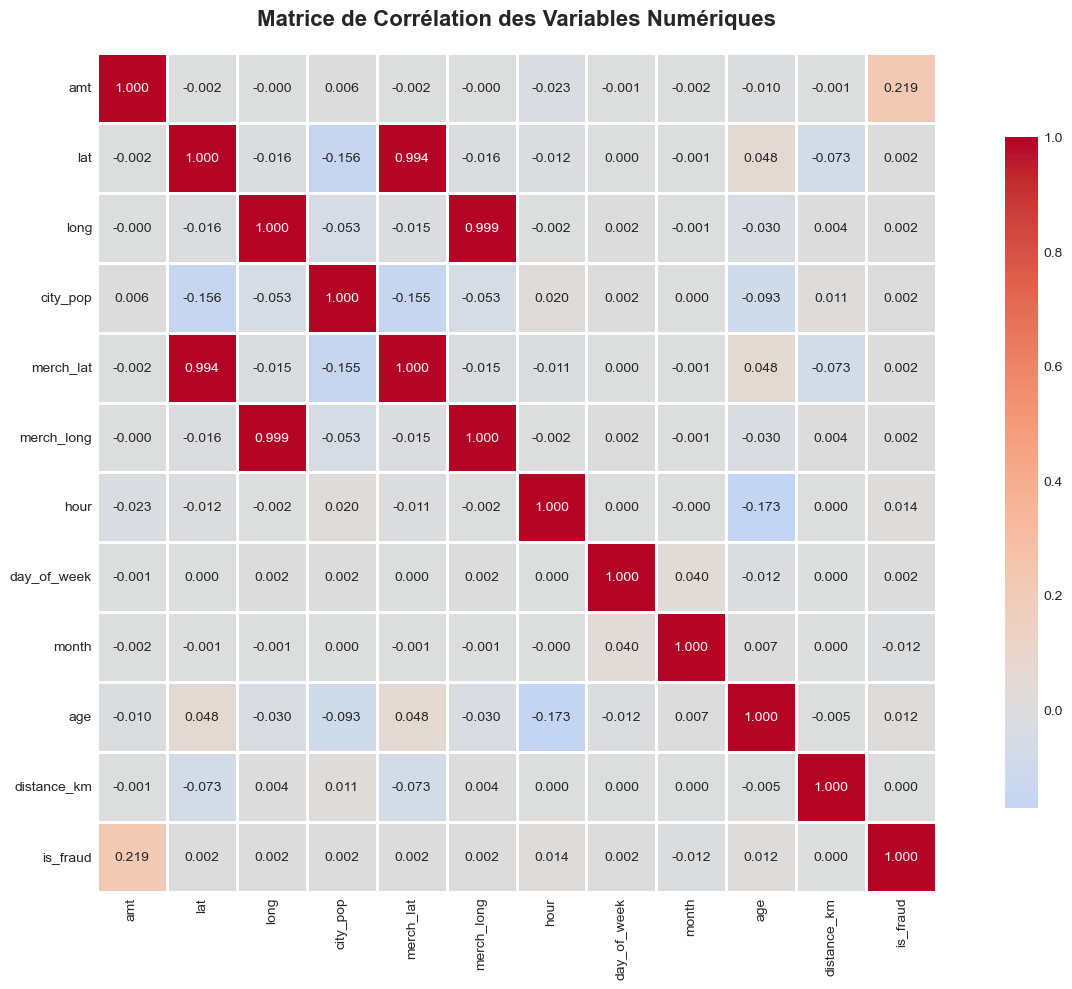

In [58]:
# Visualisation de la matrice de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Variables Numériques', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./png/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#### 13. ANALYSE AVANCÉE - PATTERNS DE FRAUDE

In [59]:
# Transactions répétées sur même carte
print("Analyse des cartes avec fraudes multiples:")

card_fraud_counts = df[df['is_fraud'] == 1].groupby('cc_num').size()
multiple_fraud_cards = card_fraud_counts[card_fraud_counts > 1]
print(f"Nombre de cartes avec fraudes multiples: {len(multiple_fraud_cards)}")
if len(multiple_fraud_cards) > 0:
    print(f"Maximum de fraudes par carte: {multiple_fraud_cards.max()}")
    print(f"Moyenne de fraudes par carte frauduleuse: {multiple_fraud_cards.mean():.2f}")


Analyse des cartes avec fraudes multiples:
Nombre de cartes avec fraudes multiples: 762
Maximum de fraudes par carte: 19
Moyenne de fraudes par carte frauduleuse: 9.85


In [60]:
# Transactions par week-end vs semaine

print("Fraudes - Week-end vs Semaine:")

weekend_fraud = df.groupby('is_weekend')['is_fraud'].agg(['sum', 'count', 'mean'])
weekend_fraud['fraud_rate'] = weekend_fraud['mean'] * 100
weekend_fraud.index = ['Semaine', 'Week-end']
print(weekend_fraud)

Fraudes - Week-end vs Semaine:
           sum   count      mean  fraud_rate
Semaine   5063  845139  0.005991    0.599073
Week-end  2443  451536  0.005410    0.541042


In [61]:
# Top commerçants avec le plus de fraudes

print("Top 10 commerçants avec le plus de fraudes:")

merchant_fraud = df[df['is_fraud'] == 1].groupby('merchant').size().sort_values(ascending=False)
print(merchant_fraud.head(10))

Top 10 commerçants avec le plus de fraudes:
merchant
fraud_Rau and Sons       49
fraud_Kozey-Boehm        48
fraud_Cormier LLC        48
fraud_Doyle Ltd          47
fraud_Vandervort-Funk    47
fraud_Kilback LLC        47
fraud_Padberg-Welch      44
fraud_Kuhn LLC           44
fraud_Terry-Huel         43
fraud_Jast Ltd           42
dtype: int64


In [62]:
# Analyse croisée: Catégorie × Période

print("Analyse croisée: Catégorie × Période de la journée:")

cross_analysis = pd.crosstab(df['category'], df['time_period'], 
                              values=df['is_fraud'], aggfunc='mean') * 100
cross_analysis

Analyse croisée: Catégorie × Période de la journée:


time_period,Après-midi (12h-18h),Matin (6h-12h),Nuit (0h-6h),Soirée (18h-24h)
category,,,,
entertainment,0.038720,0.060739,0.565111,0.429284
food_dining,0.032154,0.059952,0.660264,0.248605
gas_transport,NaN,0.077652,0.859338,NaN
grocery_net,NaN,0.070634,0.517544,NaN
grocery_pos,3.375121,0.226618,2.077447,22.075055
health_fitness,0.039603,NaN,NaN,0.270063
home,0.021172,NaN,NaN,0.299780
kids_pets,0.046094,NaN,NaN,0.376139
misc_net,1.203305,0.074051,0.735493,10.260116


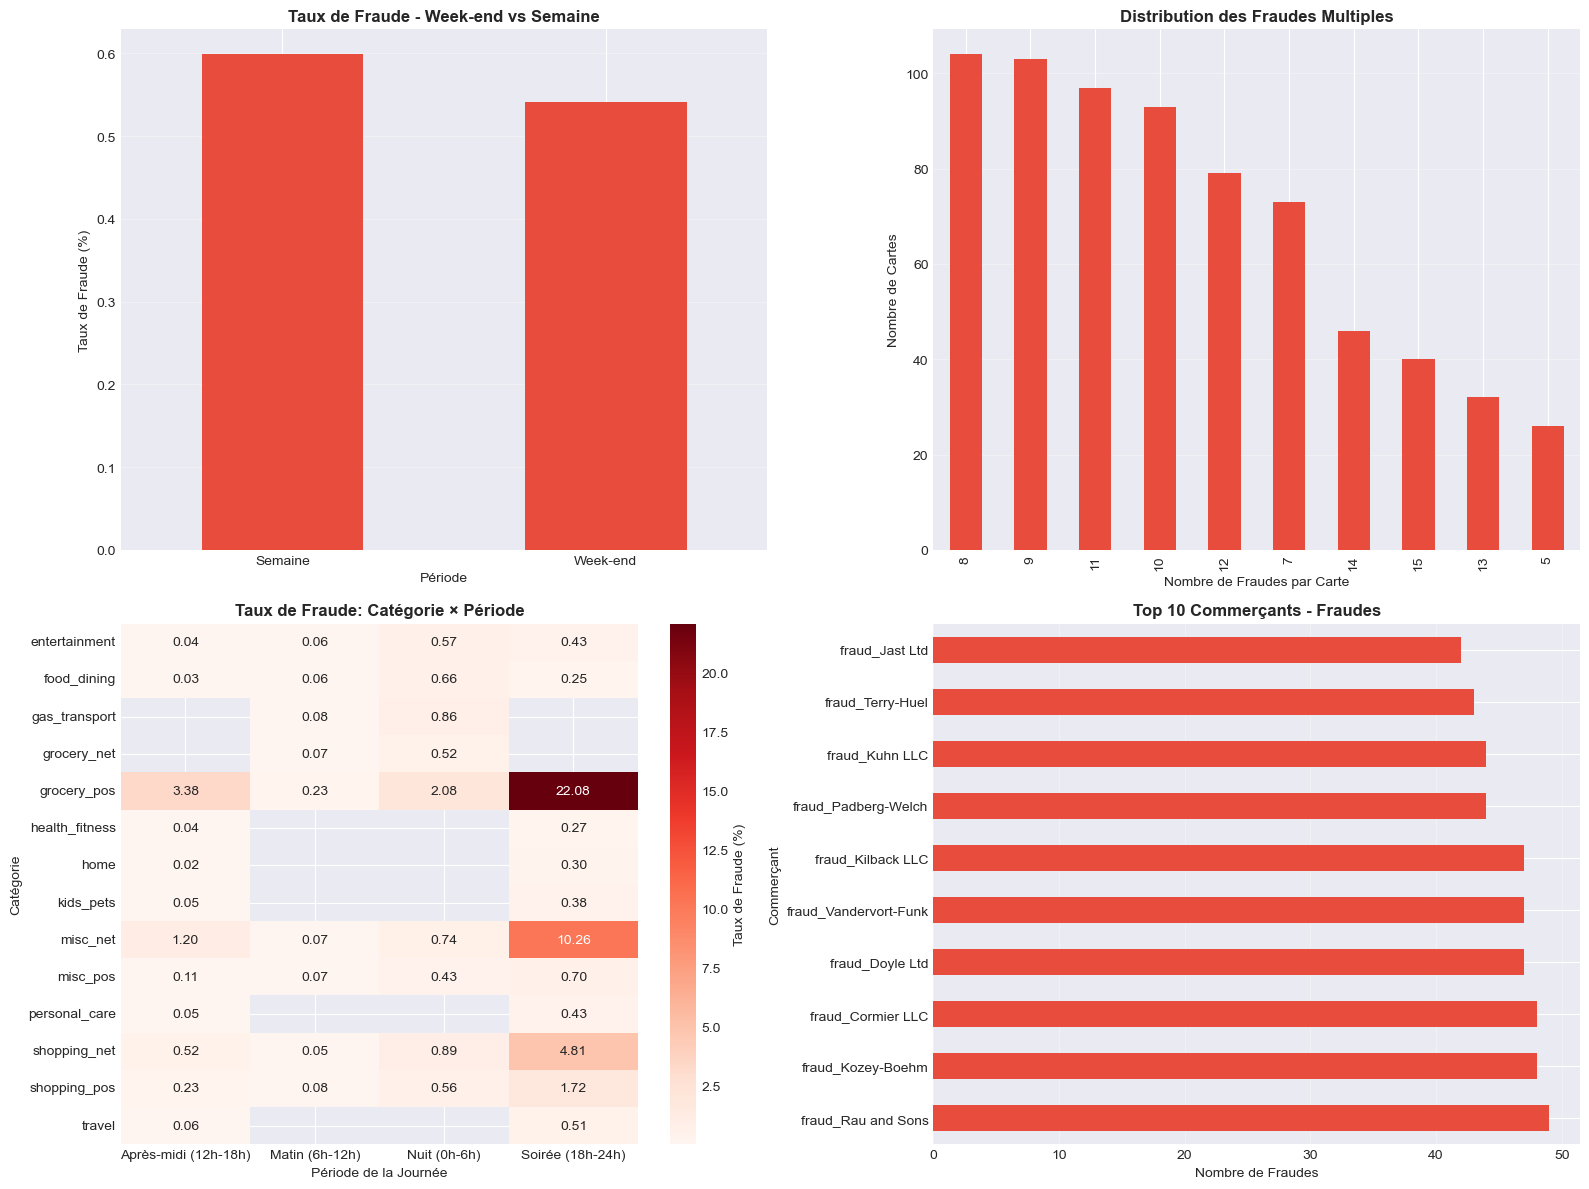

In [63]:
# Visualisation des patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Week-end vs Semaine
weekend_fraud['fraud_rate'].plot(kind='bar', ax=axes[0, 0], color='#e74c3c')
axes[0, 0].set_xlabel('Période')
axes[0, 0].set_ylabel('Taux de Fraude (%)')
axes[0, 0].set_title('Taux de Fraude - Week-end vs Semaine', fontweight='bold')
axes[0, 0].set_xticklabels(['Semaine', 'Week-end'], rotation=0)
axes[0, 0].grid(axis='y', alpha=0.3)

# Distribution des cartes avec fraudes multiples
if len(multiple_fraud_cards) > 0:
    multiple_fraud_cards.value_counts().head(10).plot(kind='bar', ax=axes[0, 1], color='#e74c3c')
    axes[0, 1].set_xlabel('Nombre de Fraudes par Carte')
    axes[0, 1].set_ylabel('Nombre de Cartes')
    axes[0, 1].set_title('Distribution des Fraudes Multiples', fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)

# Heatmap: Catégorie × Période
sns.heatmap(cross_analysis, annot=True, fmt='.2f', cmap='Reds', ax=axes[1, 0], 
            cbar_kws={'label': 'Taux de Fraude (%)'})
axes[1, 0].set_title('Taux de Fraude: Catégorie × Période', fontweight='bold')
axes[1, 0].set_xlabel('Période de la Journée')
axes[1, 0].set_ylabel('Catégorie')

# Top commerçants frauduleux
merchant_fraud.head(10).plot(kind='barh', ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_xlabel('Nombre de Fraudes')
axes[1, 1].set_ylabel('Commerçant')
axes[1, 1].set_title('Top 10 Commerçants - Fraudes', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/fraud_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

#### 14. RÉSUMÉ ET CONCLUSIONS

In [64]:
print("\n📊 RÉSUMÉ EXÉCUTIF - DÉTECTION DE FRAUDE BANCAIRE")


print(f"\n1. APERÇU DU DATASET:")
print(f"   • Total transactions: {len(df):,}")
print(f"   • Transactions frauduleuses: {df['is_fraud'].sum():,} ({df['is_fraud'].mean()*100:.2f}%)")
print(f"   • Transactions légitimes: {len(df) - df['is_fraud'].sum():,}")
print(f"   • Période couverte: {df['trans_date_trans_time'].min()} à {df['trans_date_trans_time'].max()}")

print(f"\n2. INSIGHTS FINANCIERS:")
print(f"   • Montant moyen transaction légitime: ${df[df['is_fraud']==0]['amt'].mean():.2f}")
print(f"   • Montant moyen transaction frauduleuse: ${df[df['is_fraud']==1]['amt'].mean():.2f}")
print(f"   • Montant total pertes par fraude: ${df[df['is_fraud']==1]['amt'].sum():,.2f}")

print(f"\n3. PATTERNS TEMPORELS CLÉS:")
top_hour = hourly_fraud['fraud_rate'].idxmax()
print(f"   • Heure la plus risquée: {top_hour}h (taux: {hourly_fraud.loc[top_hour, 'fraud_rate']:.2f}%)")
top_period = period_fraud['fraud_rate'].idxmax()
print(f"   • Période la plus risquée: {top_period}")
print(f"   • Différence week-end/semaine: {'Oui' if abs(weekend_fraud.loc['Week-end', 'fraud_rate'] - weekend_fraud.loc['Semaine', 'fraud_rate']) > 0.1 else 'Non significative'}")

print(f"\n4. CATÉGORIES À RISQUE:")
for idx, (cat, row) in enumerate(category_fraud.head(3).iterrows(), 1):
    print(f"   {idx}. {cat}: {row['fraud_rate']:.2f}% de fraude")

print(f"\n5. INSIGHTS GÉOGRAPHIQUES:")
top_state = state_fraud['fraud_rate'].idxmax()
print(f"   • État le plus risqué: {top_state} ({state_fraud.loc[top_state, 'fraud_rate']:.2f}%)")
print(f"   • Distance moyenne fraude: {df[df['is_fraud']==1]['distance_km'].mean():.1f} km")
print(f"   • Distance moyenne légitime: {df[df['is_fraud']==0]['distance_km'].mean():.1f} km")

print(f"\n6. PROFIL DÉMOGRAPHIQUE:")
if gender_fraud['fraud_rate'].max() - gender_fraud['fraud_rate'].min() > 0.05:
    risky_gender = gender_fraud['fraud_rate'].idxmax()
    print(f"   • Genre plus à risque: {risky_gender}")
else:
    print(f"   • Pas de différence significative par genre")
risky_age = age_fraud['fraud_rate'].idxmax()
print(f"   • Catégorie d'âge plus à risque: {risky_age}")

print("\n7. RECOMMANDATIONS POUR LA MODÉLISATION:")
print("   ✅ Variables importantes à inclure:")
print("      • Montant de la transaction (amt)")
print("      • Heure et période de la journée")
print("      • Catégorie du commerçant")
print("      • Distance client-commerçant")
print("      • Localisation géographique (état)")
print("      • Âge du client")
print("\n   ⚠️  Points d'attention:")
print("      • Dataset fortement déséquilibré → Utiliser SMOTE/sous-échantillonnage")
print("      • Importance du feature engineering temporel")
print("      • Considérer les interactions entre variables")
print("      • Valider sur période temporelle séparée")

print("\n8. PROCHAINES ÉTAPES:")
print("   1. Feature engineering avancé (agrégations, interactions)")
print("   2. Sélection de features (importance, corrélations)")
print("   3. Traitement du déséquilibre des classes")
print("   4. Entraînement de modèles (Random Forest, XGBoost, Neural Networks)")
print("   5. Optimisation des hyperparamètres")
print("   6. Évaluation (Precision, Recall, F1-Score, AUC-ROC)")
print("   7. Analyse des erreurs et amélioration itérative")

print("\n" + "=" * 80)
print("FIN DE L'ANALYSE EXPLORATOIRE")
print("=" * 80)
print("\n💾 Fichiers générés:")
print("   • fraud_distribution.png")
print("   • amount_analysis.png")
print("   • temporal_analysis.png")
print("   • category_analysis.png")
print("   • geographic_analysis.png")
print("   • demographic_analysis.png")
print("   • correlation_matrix.png")
print("   • fraud_patterns.png")
print("\n✅ Analyse terminée avec succès!")


📊 RÉSUMÉ EXÉCUTIF - DÉTECTION DE FRAUDE BANCAIRE

1. APERÇU DU DATASET:
   • Total transactions: 1,296,675
   • Transactions frauduleuses: 7,506 (0.58%)
   • Transactions légitimes: 1,289,169
   • Période couverte: 2019-01-01 00:00:18 à 2020-06-21 12:13:37

2. INSIGHTS FINANCIERS:
   • Montant moyen transaction légitime: $67.67
   • Montant moyen transaction frauduleuse: $531.32
   • Montant total pertes par fraude: $3,988,088.61

3. PATTERNS TEMPORELS CLÉS:
   • Heure la plus risquée: 22h (taux: 2.88%)
   • Période la plus risquée: Soirée (18h-24h)
   • Différence week-end/semaine: Non significative

4. CATÉGORIES À RISQUE:
   1. shopping_net: 1.76% de fraude
   2. misc_net: 1.45% de fraude
   3. grocery_pos: 1.41% de fraude

5. INSIGHTS GÉOGRAPHIQUES:
   • État le plus risqué: DE (100.00%)
   • Distance moyenne fraude: 76.3 km
   • Distance moyenne légitime: 76.1 km

6. PROFIL DÉMOGRAPHIQUE:
   • Genre plus à risque: M
   • Catégorie d'âge plus à risque: 55-65 ans

7. RECOMMANDATION